# Getting the sensitivity of the PWFS system with KL modes


The objective is to compare the sensitivity of unmodulated, modulated and 2 flavors of "Time-Resolved" modulated TRWFSs. More specifically, we are using the sensitivity to KL modes.


We start by initializing the system with OOPAO

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_CMOS_PWFS_aug2022_3 import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

param['modulation'] = 3

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


# M2C_KL = compute_M2C(telescope            = tel, \
#                      atmosphere         = atm, \
#                      deformableMirror   = dm, \
#                      param              = None, \
#                      nameFolder         = None, \
#                      nameFile           = None, \
#                      remove_piston      = True, \
#                      HHtName            = None, \
#                      baseName           = None , \
#                      mem_available      = 1e9, \
#                      minimF             = False, \
#                      nmo                = None, \
#                      ortho_spm          = True, \
#                      SZ                 = np.int64(2*tel.OPD.shape[0]), \
#                      nZer               = 3, \
#                      NDIVL              = 1, \
#                      recompute_cov=True, \
#                      save_output= False)

M2C_KL = compute_KL_basis(tel, atm, dm)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])




     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             24               [m]        
    Resolution           120             [pixels]     
    Pixel Size           0.2               [m]        
     Surface            452.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      11304            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%

# Getting the OPD of the first 10 KL modes

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


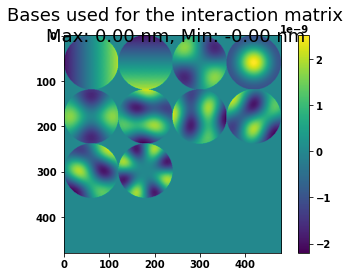

In [2]:

dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

# Getting the reference image to see if all 4 quadrants are equal

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


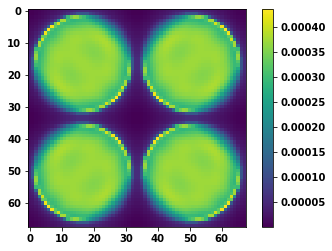

In [3]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Get the "Valid" pixels to use going forward. The other pixels dont receive enought photons.

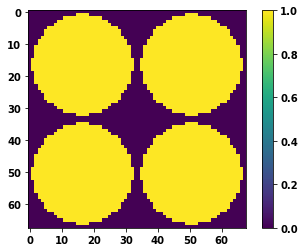

In [4]:
im_validSignal = plt.imshow(wfs.validSignal)
im_validSignal_cbar = plt.colorbar(im_validSignal)

# Calculating the weights of each frame along the modulation for the first 50 KL modes

Telescope and Atmosphere separated!
using 50 modes
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


<Figure size 432x288 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


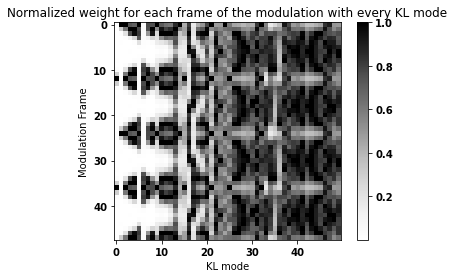

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50 #M2C_KL.shape[1]
print(f"using {nModes} modes")
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]

# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)

weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    #weighting_cube[:,i] = (np.sqrt(np.sum(i_cube[:, :, i]**2, axis=1)))
    #weighting_cube[:,i] = weighting_cube[:,i] - np.min(weighting_cube[:,i])
    #weighting_cube[:,i] = weighting_cube[:,i]  / np.max(weighting_cube[:,i])

    avg_val = np.mean(i_cube[:, :, i])
    weighting_cube[:,i] = ((np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))**2
    #weighting_cube[:,i] = weighting_cube[:,i] - np.min(weighting_cube[:,i])
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(np.abs(weighting_cube[:,i]))

plt.figure()
im = plt.imshow(weighting_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.title("Normalized weight for each frame of the modulation with every KL mode")
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")
plt.figure()



For reference, what does the "binary weights" looks like. In this case, we remove 11 frames per face for the 1st and 2nd KL mode with only 4 frames remaining.

Text(0.5, 0, 'KL mode')

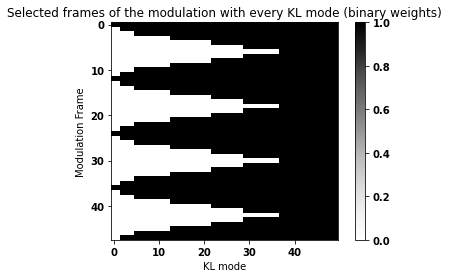

In [6]:
framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0


im = plt.imshow(binary_weight_cube, cmap=cm.Greys)
im1_cbar = plt.colorbar(im)
plt.title("Selected frames of the modulation with every KL mode (binary weights)")
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

# Now we calculate the interaction matrix for 4 flavors: unmodulated, modulated, modulated with weights and modulated with binary weights (0 or 1). We only use the first 50 KL modes for now.

Formulas used:

$$ \Delta I(\phi) = \frac{I(\phi)}{N} - \frac{I_0}{N_0}  $$ (eq. 2.11)

$$ \delta I (\phi_i) = \frac{\Delta I(\epsilon \phi_i) - \Delta I(-\epsilon \phi_i)}{2\epsilon} $$ (eq. 2.12)

$$ \mathcal{D} = ( \delta I(\phi_1), \delta I(\phi_2), ...,\delta I(\phi_{N_{modes}})  )$$ (eq. 2.13)

In [7]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = 50 #M2C_KL.shape[1]
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod

    # Get the reference image of the PWFS
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        # Get push PWFS image, keep only the "valid pixels"
        push = wfs.cam.cube[:, wfs.validSignal]
        # Normalize by the total amount of photons and substract the (also normalized) reference. Apply the weights to both (eq. 2.11)
        push_signal = (np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m])) - \
                      (np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m]))


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs
        # Get pull PWFS image, keep only the "valid pixels"
        pull = wfs.cam.cube[:, wfs.validSignal]
        # Normalize by the total amount of photons and substract the (also normalized) reference. Apply the weights to both (eq. 2.11)
        pull_signal = (np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m])) - \
                       (np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m]))

        # Get the average of the push and pull and remove contribution of the stroke (eq. 2.12)
        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)


        #imat[:,m] /= np.max(imat[:,m])
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        # Get push PWFS image, keep only the "valid pixels"
        push = wfs.cam.frame[wfs.validSignal]
        # Normalize by the total amount of photons and substract the (also normalized) reference (eq. 2.11)
        push_signal = (push/np.sum(push)) - (ref_frame/np.sum(ref_frame))

        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        # Get pull PWFS image, keep only the "valid pixels"
        pull = wfs.cam.frame[wfs.validSignal]
        # Normalize by the total amount of photons and substract the (also normalized) reference (eq. 2.11)
        pull_signal = (pull/np.sum(pull)) - (ref_frame/np.sum(ref_frame))

        # Get the average of the push and pull and remove contribution of the stroke (eq. 2.12)
        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.max(imat[:,m])

    return imat

# Calculate the interaction matrix of all 4 flavors
I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])

# Calculate the inverse of every interaction matrix
I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


# With the interaction matrix and its inverse,validate by multiplying both. This should give the identity matrix

Text(0.5, 1.0, 'Identity of binary TR reconstructor. RMS err = 5.0683693352246427e-17')

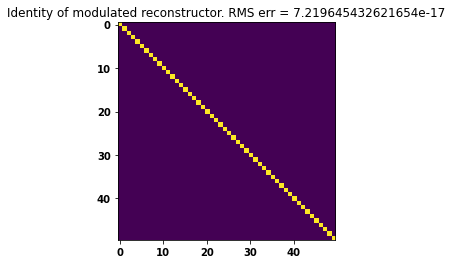

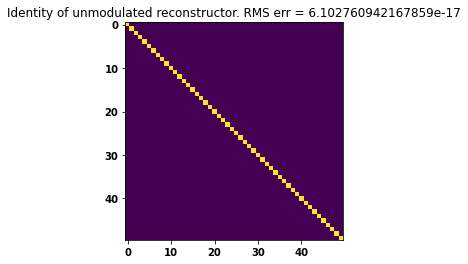

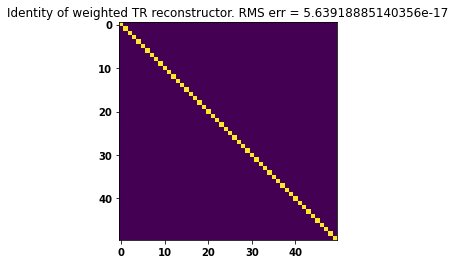

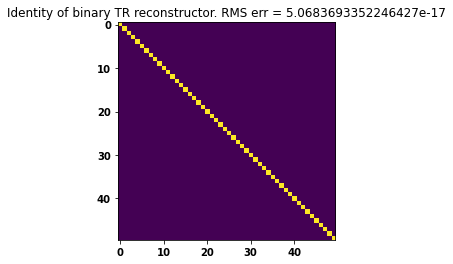

In [8]:
plt.figure()
plt.imshow((I_mat_modulated_inv@I_mat_modulated))
diag_modulated_err_rms = np.sqrt(np.mean((I_mat_modulated_inv@I_mat_modulated - np.identity(nModes))**2))
plt.title(f"Identity of modulated reconstructor. RMS err = {diag_modulated_err_rms}")
plt.figure()
plt.imshow(I_mat_unmodulated_inv@I_mat_unmodulated)
diag_unmodulated_err_rms = np.sqrt(np.mean((I_mat_unmodulated_inv@I_mat_unmodulated - np.identity(nModes))**2))
plt.title(f"Identity of unmodulated reconstructor. RMS err = {diag_unmodulated_err_rms}")
plt.figure()
plt.imshow(I_mat_weighted_inv@I_mat_weighted)
diag_weighted_err_rms = np.sqrt(np.mean((I_mat_weighted_inv@I_mat_weighted - np.identity(nModes))**2))
plt.title(f"Identity of weighted TR reconstructor. RMS err = {diag_weighted_err_rms}")
plt.figure()
plt.imshow(I_mat_binary_inv@I_mat_binary)
diag_binary_err_rms = np.sqrt(np.mean((I_mat_binary_inv@I_mat_binary - np.identity(nModes))**2))
plt.title(f"Identity of binary TR reconstructor. RMS err = {diag_binary_err_rms}")

## For a given KL (a given column of the interaction matrix), looks at the some of the stats.

In [9]:
sel_KL = 0

print(f"Unmodulated        :: KL={sel_KL}, Length={len(I_mat_unmodulated[:,sel_KL]):d}, Avg={np.mean(I_mat_unmodulated[:,sel_KL]):.2e}, std={np.std(I_mat_unmodulated[:,sel_KL]):.2f}, var={np.var(I_mat_unmodulated[:,sel_KL]):.2f}, Max={np.max(I_mat_unmodulated[:,sel_KL]):.2f}, Min={np.min(I_mat_unmodulated[:,sel_KL]):.2f}")
print(f"Modulated          :: KL={sel_KL}, Length={len(I_mat_modulated[:,sel_KL]):d}, Avg={np.mean(I_mat_modulated[:,sel_KL]):.2e}, std={np.std(I_mat_modulated[:,sel_KL]):.2f}, var={np.var(I_mat_modulated[:,sel_KL]):.2f}, Max={np.max(I_mat_modulated[:,sel_KL]):.2f}, Min={np.min(I_mat_modulated[:,sel_KL]):.2f}")
print(f"Weighted modulated :: KL={sel_KL}, Length={len(I_mat_weighted[:,sel_KL]):d}, Avg={np.mean(I_mat_weighted[:,sel_KL]):.2e}, std={np.std(I_mat_weighted[:,sel_KL]):.2f}, var={np.var(I_mat_weighted[:,sel_KL]):.2f}, Max={np.max(I_mat_weighted[:,sel_KL]):.2f}, Min={np.min(I_mat_weighted[:,sel_KL]):.2f}")
print(f"Binary modulated   :: KL={sel_KL}, Length={len(I_mat_binary[:,sel_KL]):d}, Avg={np.mean(I_mat_binary[:,sel_KL]):.2e}, std={np.std(I_mat_binary[:,sel_KL]):.2f}, var={np.var(I_mat_binary[:,sel_KL]):.2f}, Max={np.max(I_mat_binary[:,sel_KL]):.2f}, Min={np.min(I_mat_binary[:,sel_KL]):.2f}")


Unmodulated        :: KL=0, Length=3088, Avg=-3.11e-13, std=4809.53, var=23131583.40, Max=11131.07, Min=-11131.07
Modulated          :: KL=0, Length=3088, Avg=3.96e-11, std=385.81, var=148849.99, Max=627.99, Min=-627.99
Weighted modulated :: KL=0, Length=3088, Avg=2.01e-11, std=3471.53, var=12051494.31, Max=4953.06, Min=-4953.06
Binary modulated   :: KL=0, Length=3088, Avg=-1.43e-12, std=2257.01, var=5094090.24, Max=4304.78, Min=-4304.78


The near 0 average makes sense, but is it normal that the max and min values change?

# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

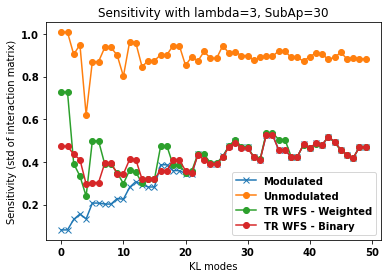

In [10]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure()
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0)) / radian_in_1m, marker="x",label="Modulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated - np.mean(I_mat_modulated, axis=0) )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}, SubAp={wfs.nSubap}")
plt.legend()

## Try another way , by getting the standard deviation along each column

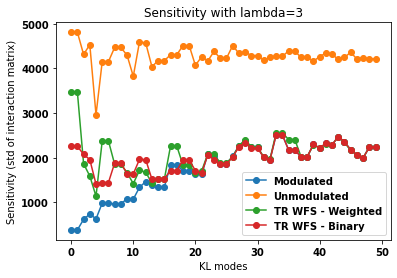

In [11]:
plt.figure()
plt.plot(np.std(I_mat_modulated, axis=0), marker="o",label="Modulated")
plt.plot(np.std(I_mat_unmodulated, axis=0), marker="o",label="Unmodulated")
plt.plot(np.std(I_mat_weighted, axis=0), marker="o", label="TR WFS - Weighted")
plt.plot(np.std(I_mat_binary, axis=0), marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}")
plt.legend()

## Trying to reproduce the formula 3.20 from Chambouleron's thesis.

$$ s_\gamma (\phi_i) = \| \frac{\delta I(\phi_i)}{\sqrt{I_0}} \|_2 $$

In [12]:
tel - atm
wfs.cam.photonNoise = False
nModes = 50
stroke = 1*1e-9


def getSensitivityModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = int(wfs.cam.cube[:, wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.cube[:, wfs.validSignal])
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.cube[:, wfs.validSignal])
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        imat[:,m] = imat[:,m] / np.sqrt(np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m]))
        #imat[:,m] /= np.max(imat[:,m] )
    return imat

def getSensitivityUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = int(wfs.cam.frame[wfs.validSignal])

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = int(wfs.cam.frame[wfs.validSignal])
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = int(wfs.cam.frame[wfs.validSignal])
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)



        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)

        # Divide by the square root of the normalized reference image
        imat[:,m] = imat[:,m] / np.sqrt(ref_frame/np.sum(ref_frame))
        #imat[:,m] /= np.max(imat[:,m] )

    return imat

s_y_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
s_y_unmodulated = getInterationMatrixUnmodulated()
s_y_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
s_y_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Take each column and get the square norm ($L^2$)

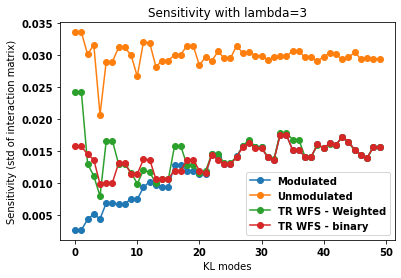

In [13]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure()
plt.plot(np.sqrt(np.sum(np.square(s_y_modulated), axis=0))/ radian_in_1m, marker="o", label="Modulated")
plt.plot(np.sqrt(np.sum(np.square(s_y_unmodulated), axis=0))/ radian_in_1m, marker="o", label="Unmodulated")
plt.plot(np.sqrt(np.sum(np.square(s_y_weighted), axis=0))/ radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(np.sum(np.square(s_y_binary), axis=0))/ radian_in_1m, marker="o", label="TR WFS - binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}")
plt.legend()

In [14]:
from OOPAO.calibration.CalibrationVault import CalibrationVault

I_mat_weighted_o=CalibrationVault(I_mat_weighted,invert=True)
calib_KL_weighted = CalibrationVault(I_mat_weighted_o.D@M2C_KL.T)



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 662 is different from 50)